In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # to print multiple outputs from the same cell
import math
import utils
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from operator import index
from collections import defaultdict
from scipy.stats import pearsonr
from datetime import datetime

In [2]:
tweets_df = pd.read_csv("../dataset/tweets.csv")
users_df = pd.read_csv("../dataset/users_dataset_cleaned.csv")

# Tweets Data Understanding and Preparation

In tweets.csv each row contains information about a single tweet. There are 10 columns and In this case the variables are:

1. ID: a unique identifier for the tweet

2. User Id: a unique identifier for the user who wrote the tweet

3. Retweet count: number of retweets for the tweet in analysis

4. Reply count: number of reply for the tweet in analysis

5. Favorite count: number of favorites (likes) received by the tweet

6. Num hashtags: number of hashtags used in the tweet

7. Num urls: number of urls in the tweet

8. Num mentions: number of mentions in the tweet

9. Created at: when the tweet was created

10. Text: the text of the tweet


In [3]:
tweets_df.info(verbose=True, show_counts=True, memory_usage= "deep") 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13664696 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   id              13664694 non-null  object
 1   user_id         13447413 non-null  object
 2   retweet_count   13227562 non-null  object
 3   reply_count     13016818 non-null  object
 4   favorite_count  13017154 non-null  object
 5   num_hashtags    12607172 non-null  object
 6   num_urls        13016073 non-null  object
 7   num_mentions    12810531 non-null  object
 8   created_at      13664696 non-null  object
 9   text            13126975 non-null  object
dtypes: object(10)
memory usage: 8.9 GB


# 1. Tweet_id & User_id Columns

keeping only the tweets with user_id in user dataset. As these are the ones we would like to study, and have the data to verify the validity of.

In [4]:
tweets_df.rename(columns= {"id" : "tweet_id"}, inplace=True)

In [5]:
before_dropping_rows_number = len(tweets_df.index)

numeric_ids = pd.to_numeric(tweets_df["user_id"], errors="coerce")
ids_are_not_in_users_df = numeric_ids[numeric_ids.isin(users_df["user_id"]) == False]
tweets_df.drop(ids_are_not_in_users_df.index, inplace=True)

tweets_df["user_id"] = pd.to_numeric(tweets_df["user_id"], errors="coerce")

after_dropping_rows_number = len(tweets_df.index)

print(f"Percentage of tweets whose author id isn't inside the users dataframe: {(100*(before_dropping_rows_number-after_dropping_rows_number))/(before_dropping_rows_number)}")

Percentage of tweets whose author id isn't inside the users dataframe: 3.56021092602426


clean id field by casting to int

In [6]:
tweets_df["tweet_id"] = pd.to_numeric(tweets_df["tweet_id"], errors="coerce") # cast field to int and set invalid values to NaN

removing tweets which are duplicates on every attribute

In [7]:
original_number_rows = len(tweets_df.index)

all_columns_duplicated_df = tweets_df[tweets_df.duplicated(subset=None, keep="first")]
all_columns_duplicated_number = len(all_columns_duplicated_df.index)

print(f"Percentage of tweets duplicated along all the columns that we are deleting(after keeping the first instance): {(100*(all_columns_duplicated_number))/original_number_rows}")

tweets_df.drop(labels=all_columns_duplicated_df.index, inplace=True)

Percentage of tweets duplicated along all the columns that we are deleting(after keeping the first instance): 14.75545529572922


Dropping tweets whose id is an invalid value (i.e. NaN, duplicate, inf)

In [8]:
before = tweets_df.size
tweets_df = tweets_df[tweets_df['tweet_id'].notna()]
after= tweets_df.size
print(f"Percentage of tweets with nan tweet_id dropped: {(100*(before - after))/before}")

Percentage of tweets with nan tweet_id dropped: 3.333923818510375


In [9]:
before = tweets_df.size
tweets_df = tweets_df.drop_duplicates(subset="tweet_id")
after = tweets_df.size
print(f"Num of tweets with same tweet_id dropped: {(before - after)}")

Num of tweets with same tweet_id dropped: 5490


In [10]:
before = tweets_df.size
tweets_df = tweets_df[tweets_df['tweet_id']!=np.inf]
after = tweets_df.size
print(f"Num of tweets with inf tweet_id dropped: {(before - after)}")

Num of tweets with inf tweet_id dropped: 10


We have decided to drop all tweets with NaN values as their ID. As it is difficult for us to ensure their validity. We have also decided to drop all tweets with duplicated IDs. Keeping only its first instance. 

Lets see if we can find the tweets with non-NaN user-id values.

In [11]:
before = tweets_df.size
tweets_df = tweets_df[tweets_df['user_id'].notna()]
after= tweets_df.size
print(f"Percentage of tweets with nan user_id dropped: {(100*(before - after))/before}")

Percentage of tweets with nan user_id dropped: 0.0


Convert tweet_id attribute to int64

In [12]:
tweets_df["tweet_id"] = tweets_df["tweet_id"].astype(np.int64)
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858627 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tweet_id        int64 
 1   user_id         int64 
 2   retweet_count   object
 3   reply_count     object
 4   favorite_count  object
 5   num_hashtags    object
 6   num_urls        object
 7   num_mentions    object
 8   created_at      object
 9   text            object
dtypes: int64(2), object(8)
memory usage: 911.3+ MB


# 2. Numerical columns

- Retweet_count
- Reply_count
- favorite_count
- Num_hashtags
- Num_urls
- num_mentions

In [13]:
columns = ["retweet_count", "reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions"]
tweets_df[columns].describe()

,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,10589136,10480175,10479681,10259405,10479096,10369956
unique,181213,117598,117707,77700,116554,97775
top,0,0,0,0,0,0
freq,7540372,9803697,7866507,8704827,8223779,6116211


For each column, we apply a upper bound threshold alongside the removal on NaN and negative values

In [14]:
thresholds = {
   "retweet_count": 3738380,
   "favorite_count": 7114892,
   "reply_count" : 4000000,
   "num_hashtags" : 93,
   "num_urls" : 23,
   "num_mentions": 93
}

print("Number of invalid values for the following columns:")
for column_name in columns:
   # casting all the columns to numeric (and setting invalid value to null)
   tweets_df[column_name] = pd.to_numeric(tweets_df[column_name], errors="coerce")

   print(f"{column_name}")
   # evaluating the presence of negative values
   negative_series = tweets_df[tweets_df[column_name] < 0][column_name]
   print(f"\tnegative: {len(negative_series)}")
   tweets_df[column_name].loc[negative_series.index] = np.NaN # setting negative values to NaN
   
   # evaluating the presence of inf values
   inf_series = utils.get_inf_elements(tweets_df[column_name])
   print(f"\tinf: {len(inf_series)}")
   tweets_df[column_name].loc[inf_series.index] = np.NaN # setting inf values to NaN

   # evaluating the presence of decimal values
   is_float = lambda n: (not pd.isna(n)) and (not math.isinf(n)) and (not n.is_integer())
   decimal_values_series =  tweets_df[column_name].apply(is_float)
   print(f"\tdecimals: {len(tweets_df[column_name][decimal_values_series])}")
   
   # finding values above given thresholds (if specified)
   if column_name in thresholds:
       threshold = thresholds[column_name]
       above_threshold_series = tweets_df[tweets_df[column_name] > threshold ][column_name]
       print(f"\tvalues above threshold ({threshold}): {len(above_threshold_series[above_threshold_series > threshold])}") 
       tweets_df[column_name].loc[above_threshold_series.index] = np.NaN # setting values above threshold to nan



Number of invalid values for the following columns:
retweet_count
	negative: 0


/var/folders/dr/2s7v59v56_7dprnthphy_3sh0000gn/T/ipykernel_4131/3643846531.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df[column_name].loc[negative_series.index] = np.NaN # setting negative values to NaN


	inf: 1


/var/folders/dr/2s7v59v56_7dprnthphy_3sh0000gn/T/ipykernel_4131/3643846531.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df[column_name].loc[inf_series.index] = np.NaN # setting inf values to NaN


	decimals: 0
	values above threshold (3738380): 36


/var/folders/dr/2s7v59v56_7dprnthphy_3sh0000gn/T/ipykernel_4131/3643846531.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df[column_name].loc[above_threshold_series.index] = np.NaN # setting values above threshold to nan


reply_count
	negative: 0
	inf: 1
	decimals: 0
	values above threshold (4000000): 42
favorite_count
	negative: 1
	inf: 0
	decimals: 0
	values above threshold (7114892): 34
num_hashtags
	negative: 0
	inf: 0
	decimals: 0
	values above threshold (93): 279
num_urls
	negative: 0
	inf: 0
	decimals: 0
	values above threshold (23): 469
num_mentions
	negative: 0
	inf: 0
	decimals: 0
	values above threshold (93): 381


### Parsing columns to integer

Substituting NaN values with median

In [15]:
for column in columns:
    # Set to nan the values higher than the max integer 
    # Probably noise values
    tweets_df[tweets_df[column] > float(np.iinfo(np.int64).max)][column] = np.nan
    # Nans to median
    tweets_df[column] = tweets_df.groupby("user_id")[column].apply(lambda x: x.fillna(int(x.median())))
    # Cast column to int
    tweets_df[column] = tweets_df[column].astype(np.int64)

retweet_count     578.764329
reply_count         1.115122
favorite_count      3.557494
num_hashtags        0.176419
num_urls            0.164779
num_mentions        0.527135
dtype: float64

578.7643288625314

/var/folders/dr/2s7v59v56_7dprnthphy_3sh0000gn/T/ipykernel_4131/1776047286.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tweets_df[column] = tweets_df.groupby("user_id")[column].apply(lambda x: x.fillna(int(x.median())))


1.1151222959465295

/var/folders/dr/2s7v59v56_7dprnthphy_3sh0000gn/T/ipykernel_4131/1776047286.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tweets_df[column] = tweets_df.groupby("user_id")[column].apply(lambda x: x.fillna(int(x.median())))


3.5574937796450663

/var/folders/dr/2s7v59v56_7dprnthphy_3sh0000gn/T/ipykernel_4131/1776047286.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tweets_df[column] = tweets_df.groupby("user_id")[column].apply(lambda x: x.fillna(int(x.median())))


0.1764191934709478

/var/folders/dr/2s7v59v56_7dprnthphy_3sh0000gn/T/ipykernel_4131/1776047286.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tweets_df[column] = tweets_df.groupby("user_id")[column].apply(lambda x: x.fillna(int(x.median())))


0.16477911795050385

/var/folders/dr/2s7v59v56_7dprnthphy_3sh0000gn/T/ipykernel_4131/1776047286.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tweets_df[column] = tweets_df.groupby("user_id")[column].apply(lambda x: x.fillna(int(x.median())))


0.5271346284165349

/var/folders/dr/2s7v59v56_7dprnthphy_3sh0000gn/T/ipykernel_4131/1776047286.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tweets_df[column] = tweets_df.groupby("user_id")[column].apply(lambda x: x.fillna(int(x.median())))


In [16]:
tweets_df[columns].quantile([0.25, 0.5, 0.75, 0.87, 0.95, 0.99, 0.999, 0.9999, 0.99999, 0.999999])
tweets_df[columns].mean()
tweets_df[columns].median()
tweets_df[columns].describe()

,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
0.250000,0.000000e+00,0.000000,0.0000,0.000000,0.0,0.00000
0.500000,0.000000e+00,0.000000,0.0000,0.000000,0.0,0.00000
0.750000,1.000000e+00,0.000000,0.0000,0.000000,0.0,1.00000
0.870000,5.000000e+00,0.000000,1.0000,0.000000,1.0,1.00000
0.950000,4.080000e+02,0.000000,2.0000,1.000000,1.0,2.00000
0.990000,7.125000e+03,0.000000,7.0000,3.000000,1.0,3.00000
0.999000,1.130110e+05,1.000000,44.0000,6.000000,2.0,7.00000
0.999900,3.849450e+05,19.000000,3036.1374,10.000000,3.0,10.00000
0.999990,3.350015e+06,3735.068700,18690.1220,15.000000,4.0,12.00000
0.999999,3.350106e+06,242214.470161,135299.0000,56.989618,6.0,49.41374


retweet_count     557.356192
reply_count         1.064020
favorite_count      3.402434
num_hashtags        0.167615
num_urls            0.159207
num_mentions        0.522796
dtype: float64

retweet_count     0.0
reply_count       0.0
favorite_count    0.0
num_hashtags      0.0
num_urls          0.0
num_mentions      0.0
dtype: float64

,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,1.085863e+07,1.085863e+07,1.085863e+07,1.085863e+07,1.085863e+07,1.085863e+07
mean,5.573562e+02,1.064020e+00,3.402434e+00,1.676147e-01,1.592073e-01,5.227962e-01
std,1.401281e+04,9.719157e+02,3.043163e+03,6.108903e-01,3.725180e-01,8.061519e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,3.350111e+06,2.000000e+06,7.000000e+06,9.300000e+01,2.200000e+01,9.100000e+01


# 3. Created_at Column

created_at should be datetime

Checks if all the tweets were created after the first tweet published on twitter (so we don't have something strange like a tweet created in 01-01-1990)

In [17]:
tweets_df["created_at"] = pd.to_datetime(tweets_df["created_at"], errors="coerce")

# finding tweets created before twitter first tweet
before_time_tweets_df = tweets_df[tweets_df["created_at"] < datetime(2006,3,21,12,50,0)]

# finding tweets created after dataset release
after_time_tweets_df = tweets_df[tweets_df["created_at"] > datetime(2022,9,29,11,0,0)]

# dropping out of range tweets
tweets_df = tweets_df.drop(before_time_tweets_df.index)
tweets_df = tweets_df.drop(after_time_tweets_df.index)

# 4. Text Column

Removing tweets with null text field, float text field or only spaces, because these are not allowed by twitter

In [19]:
tweets_df.dropna(subset=["text"], inplace=True) # drop the tweets where the text field is null
tweets_df["text"] = tweets_df["text"].astype(str) # cast the text field to string
tweets_df = tweets_df[~tweets_df.text.str.isspace()]

tweets_df.info(verbose=True, show_counts=True, memory_usage= "deep") 
tweets_df.describe()
# Problem with memory usage, we have to find a more effient way to remove tweets with only spaces
# We should also drop the tweets only containing the U+3164 HANGUL FILLER, or other invisible charackters.
#Source: https://invisible-characters.com/

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10460636 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype         
---  ------          --------------     -----         
 0   tweet_id        10460636 non-null  int64         
 1   user_id         10460636 non-null  int64         
 2   retweet_count   10460636 non-null  int64         
 3   reply_count     10460636 non-null  int64         
 4   favorite_count  10460636 non-null  int64         
 5   num_hashtags    10460636 non-null  int64         
 6   num_urls        10460636 non-null  int64         
 7   num_mentions    10460636 non-null  int64         
 8   created_at      10460636 non-null  datetime64[ns]
 9   text            10460636 non-null  object        
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 2.2 GB


,tweet_id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,1.046064e+07,1.046064e+07,1.046064e+07,1.046064e+07,1.046064e+07,1.046064e+07,1.046064e+07,1.046064e+07
mean,4.797206e+17,8.292025e+08,5.590582e+02,9.936470e-01,3.405883e+00,1.703234e-01,1.609096e-01,5.228099e-01
std,1.562081e+17,8.513559e+08,1.394359e+04,9.726417e+02,3.099434e+03,6.166258e-01,3.741349e-01,8.112720e-01
min,3.460000e+02,6.780330e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.680207e+17,2.364496e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.257476e+17,4.680642e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.777142e+17,1.199715e+09,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,9.999952e+17,3.164942e+09,3.350111e+06,2.000000e+06,7.000000e+06,9.300000e+01,2.200000e+01,9.100000e+01


'\nto_drop = []\nfor index, row in tweets_df.iterrows():\n    if row["text"].isspace():\n        tweets_df.drop(index)\n'

# 5. Distribution of variables and statistics

Histograms for numerical fields

array([[<AxesSubplot: title={'center': 'retweet_count'}>,
        <AxesSubplot: title={'center': 'reply_count'}>],
       [<AxesSubplot: title={'center': 'favorite_count'}>,
        <AxesSubplot: title={'center': 'num_hashtags'}>],
       [<AxesSubplot: title={'center': 'num_urls'}>,
        <AxesSubplot: title={'center': 'num_mentions'}>]], dtype=object)

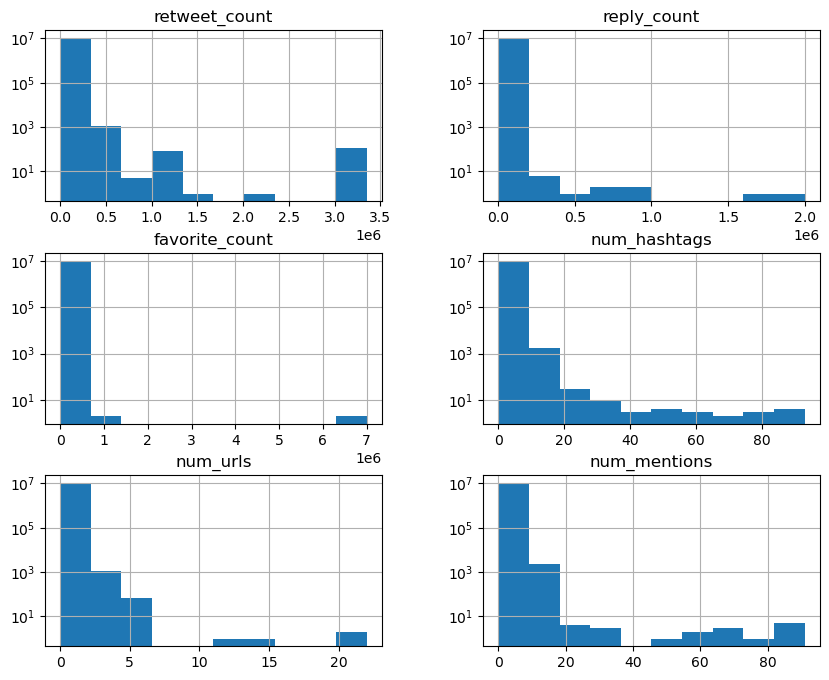

In [20]:
columns = ["retweet_count", "reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions"]

tweets_df.hist(
    column=columns, figsize=(10,8),
    log=True
)

Boxplots for the numerical fields.

<AxesSubplot: >

'\nfor column in columns:\n    tweets_df.plot(kind="box",\n        column=column,\n        logy=True\n    )\n    '

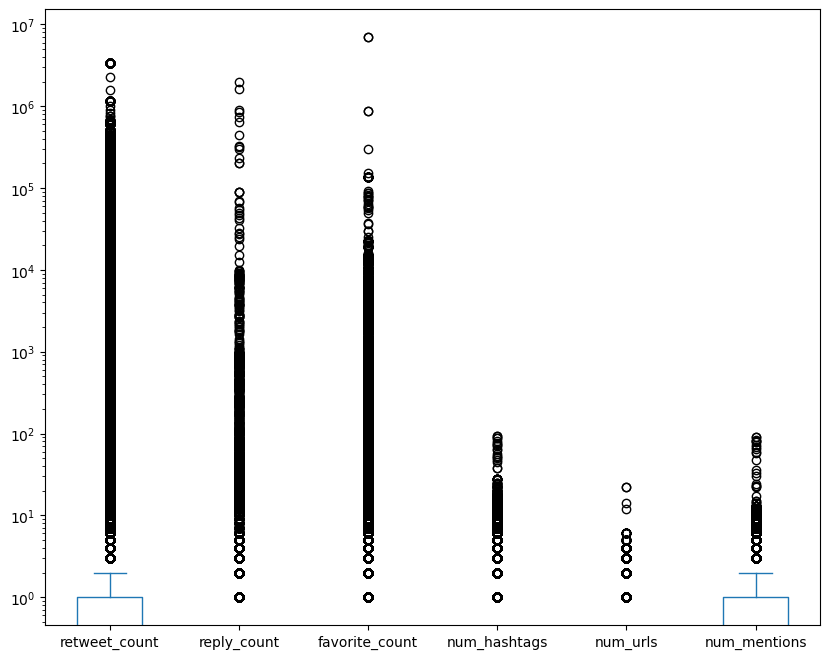

In [21]:
tweets_df[columns].plot(kind="box",
        figsize=(10,8),
        logy=True, 
    )

In [22]:
tweets_df[columns].mean()
tweets_df[columns].median()

retweet_count     559.058241
reply_count         0.993647
favorite_count      3.405883
num_hashtags        0.170323
num_urls            0.160910
num_mentions        0.522810
dtype: float64

retweet_count     0.0
reply_count       0.0
favorite_count    0.0
num_hashtags      0.0
num_urls          0.0
num_mentions      0.0
dtype: float64

By looking at the boxplots we can see that there is a very high variance for the data (an observation supported also by the previous histograms). Hence, we compute the whiskers upper and lower bounds analitically for each column.

In [25]:
# outlier detection
outlier_thresholds = {
    column: utils.compute_whiskers(tweets_df[column])
    for column in columns
}

outlier_dataframes = {
    column: tweets_df[tweets_df[column] > outlier_thresholds[column][1]][column]
    for column in columns
}

for column in columns:
    print(f"{column}: {len(outlier_dataframes[column])} outliers")

# Should add what percentage of the dataframe that this consists of.
# In this way we get a feeling of how many outliers our cleaned dataset consists of


retweet_count: 1648136 outliers
reply_count: 16939 outliers
favorite_count: 2033412 outliers
num_hashtags: 1147369 outliers
num_urls: 1659939 outliers
num_mentions: 231907 outliers


These outliers may be removed from the dataframe by running the code block bellow.

In [26]:
# # removal of outliers
# outlier_indexes_list = [outlier_dataframe.index for outlier_dataframe in outlier_dataframes.values()]
# for indexes in outlier_indexes_list:
#     tweets_df.drop(indexes, inplace=True, errors="ignore")

# Tweet Data Quality Summary

In [27]:
tweets_df.info(verbose=True, show_counts=True, memory_usage= "deep") 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10460636 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype         
---  ------          --------------     -----         
 0   tweet_id        10460636 non-null  int64         
 1   user_id         10460636 non-null  int64         
 2   retweet_count   10460636 non-null  int64         
 3   reply_count     10460636 non-null  int64         
 4   favorite_count  10460636 non-null  int64         
 5   num_hashtags    10460636 non-null  int64         
 6   num_urls        10460636 non-null  int64         
 7   num_mentions    10460636 non-null  int64         
 8   created_at      10460636 non-null  datetime64[ns]
 9   text            10460636 non-null  object        
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 2.2 GB


In [29]:
tweets_df.to_csv("../dataset/tweets_dataset_cleaned.csv",index=False)